In [130]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import os
import zipfile

import matplotlib.pyplot as plt

In [131]:
lr = 0.01
batch_size = 100 
epochs = 10 

In [132]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [133]:
os.makedirs('../data', exist_ok=True)

In [134]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [135]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [136]:
os.listdir(train_dir)[:5]

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg']

In [137]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

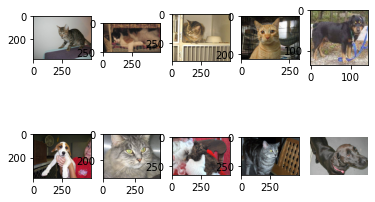

In [138]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [139]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [140]:
# data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [141]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    # 데이터 길이
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    # 이미지 로드
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        # dog면 label 1로 설정 고양이면 label 0으로 설정
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [142]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

# 데이터 로드
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [143]:
# 이미지 모양 확인
train_data[0][0].shape

torch.Size([3, 224, 224])

In [144]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [145]:
# 모델 인스턴스 생성 및 학습 모드로 변경
model = Cnn().to(device)
model.train()

# Optimizer와 Loss Function 설정
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [146]:
epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.6338001489639282, train loss : 0.6300827860832214
Epoch : 1, val_accuracy : 0.6872000098228455, val_loss : 0.5843421816825867
Epoch : 2, train accuracy : 0.6986500024795532, train loss : 0.5704298615455627
Epoch : 2, val_accuracy : 0.7042000889778137, val_loss : 0.5730758905410767
Epoch : 3, train accuracy : 0.7220503687858582, train loss : 0.5387381911277771
Epoch : 3, val_accuracy : 0.7001999616622925, val_loss : 0.5642238855361938
Epoch : 4, train accuracy : 0.7360000610351562, train loss : 0.5231713652610779
Epoch : 4, val_accuracy : 0.7515999674797058, val_loss : 0.5072439312934875
Epoch : 5, train accuracy : 0.7472000122070312, train loss : 0.5044175982475281
Epoch : 5, val_accuracy : 0.7407999634742737, val_loss : 0.5159716010093689
Epoch : 6, train accuracy : 0.7560499906539917, train loss : 0.49192434549331665
Epoch : 6, val_accuracy : 0.7466001510620117, val_loss : 0.501863956451416
Epoch : 7, train accuracy : 0.7616000771522522, train loss : 0.4

In [147]:
# 강아지일 가능성을 나타내는 확률을 담을 빈 리스트
dog_probs = []
model.eval() # 평가 모드로 전환
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [148]:
dog_probs.sort(key = lambda x : int(x[0])) # 오름차순으로 정렬
dog_probs

[('1', 0.40764740109443665),
 ('2', 0.9822376370429993),
 ('3', 0.8157041668891907),
 ('4', 0.9879201650619507),
 ('5', 0.0529884472489357),
 ('6', 0.7368709444999695),
 ('7', 0.15269863605499268),
 ('8', 0.20800836384296417),
 ('9', 0.2439310997724533),
 ('10', 0.41765016317367554),
 ('11', 0.00967779103666544),
 ('12', 0.5210400819778442),
 ('13', 0.0632321685552597),
 ('14', 0.3183738887310028),
 ('15', 0.4604703187942505),
 ('16', 0.04540316015481949),
 ('17', 0.8925022482872009),
 ('18', 0.9272254705429077),
 ('19', 0.15568988025188446),
 ('20', 0.5515732765197754),
 ('21', 0.930934727191925),
 ('22', 0.3587741255760193),
 ('23', 0.7673011422157288),
 ('24', 0.4935511648654938),
 ('25', 0.5479398965835571),
 ('26', 0.8070251941680908),
 ('27', 0.8061811923980713),
 ('28', 0.026026751846075058),
 ('29', 0.834351658821106),
 ('30', 0.6072924733161926),
 ('31', 0.9661680459976196),
 ('32', 0.045160021632909775),
 ('33', 0.9905588626861572),
 ('34', 0.7264618873596191),
 ('35', 0.4517

In [149]:
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

In [150]:
result = pd.DataFrame({'id':idx,'label':prob}) # 결과를 데이터프레임으로 변환
result

,id,label
0,1,0.407647
1,2,0.982238
2,3,0.815704
3,4,0.987920
4,5,0.052988
...,...,...
12495,12496,0.116972
12496,12497,0.419298
12497,12498,0.177953
12498,12499,0.954541


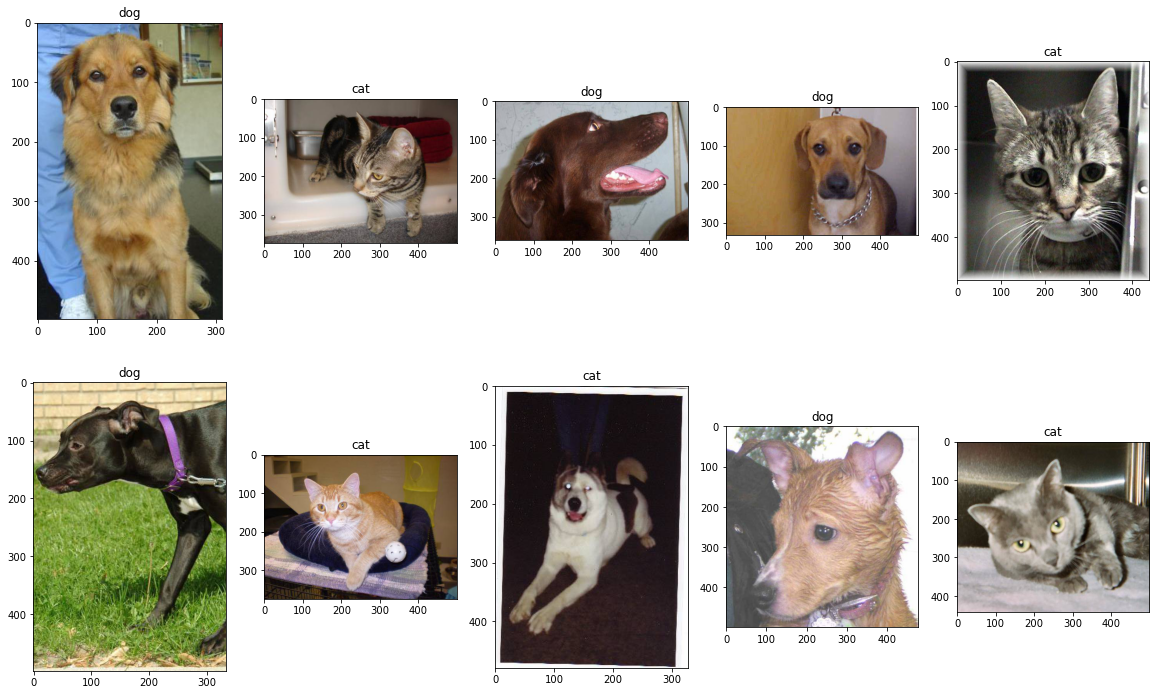

In [151]:
# 분류 결과 시각화
import random

id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(result['id'].values)
    
    label = result.loc[result['id'] == i, 'label'].values[0]
    # 0.5보다 크면 강아지로 분류
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_dir, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)